In [2]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
import astroddpm
import tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, DiscreteSDE, ContinuousSDE, ContinuousVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 
import arviz as az

In [3]:
from cmb_hmc.hmc_torch import HMC

In [4]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 3

MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_N_1000_bottleneck_32_firstc_10_phi'
#MODEL_ID = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6_phi_beta_cosine'
#MODEL_ID = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_4000_bottleneck_32_firstc_10_phi'

In [6]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [7]:
batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[1:2]

In [8]:
NUM_CHAIN = 8

In [9]:
NOISE_LEVEL = 0.1
##Closest time step to the noise level requested
TIME_STEP = diffuser.diffmodel.sde.get_closest_timestep(torch.tensor(NOISE_LEVEL))
print(f"Time step chosen for noise level {NOISE_LEVEL}: {TIME_STEP}")

Time step chosen for noise level 0.1: 0.02699493244290352


In [10]:
TIME_STEP = TIME_STEP.to(device)
TIME_STEP

tensor(0.0270, device='cuda:0')

In [11]:
phi_true = diffuser.diffmodel.ps.sample_phi(100).mean(dim = 0, keepdim=True).to(device)
ps = diffuser.diffmodel.ps(phi_true)
rphi_true = diffuser.diffmodel.ps.rescale_phi(phi_true)
sq_ps = torch.sqrt(ps).to(device)

noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, TIME_STEP, sq_ps)

In [326]:
batch = image.repeat(NUM_CHAIN, 1, 1, 1)
ps_0, phi_0 = diffuser.diffmodel.ps.sample_ps(NUM_CHAIN)
rphi_0 = diffuser.diffmodel.ps.rescale_phi(phi_0)
batch_mean = mean.repeat(NUM_CHAIN, 1, 1, 1)
noisy_batch = noisy.repeat(NUM_CHAIN, 1, 1, 1)

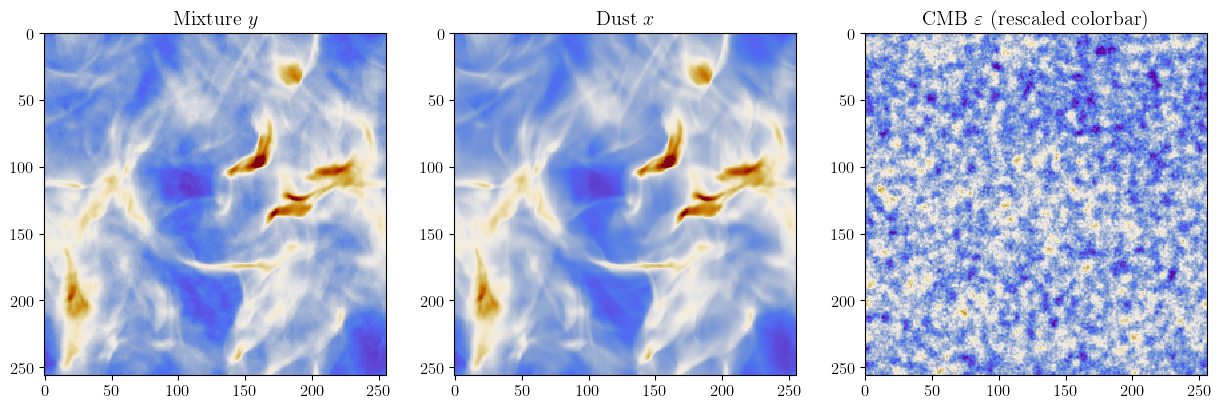

In [327]:
## Plot the noisy image along with the noise and baseline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[0].set_title('Mixture $y$')
ax[1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[1].set_title('Dust $x$')
ax[2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[2].set_title(r'CMB $\varepsilon$ (rescaled colorbar)')
#plt.savefig('inference_mixture_{:.2f}.pdf'.format(NOISE_LEVEL), bbox_inches='tight')
plt.show()

In [328]:
ps_model = diffuser.diffmodel.ps

In [329]:
def sample_prior(n):
    """
    Sample from the (normalized) prior distribution.
    phi = (H0, Obh2) with H0 ~ U(-1, 1), Obh2 ~ U(-1, 1)
    (unnormalized prior is H0 ~ U(50, 90), Obh2 ~ U(0.0075, 0.0567))
    """
    phi = 2*torch.rand(n, 2).to(device)-1
    return phi

def log_likelihood(rphi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(rphi, to_rescale = False)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2, -3)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2, -3))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi + term_logdet + term_x

def log_prior(rphi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = rphi[..., 0], rphi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= -1.0, H0 <= 1.0).float()/2.0)
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= -1.0, Obh2 <= 1.0).float()/2.0)
    return term_H0 + term_Obh2

def log_posterior(rphi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(rphi, x) + log_prior(rphi)

def log_likelihood_on_a_grid(rphi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(rphi, to_rescale = False)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi, term_logdet, term_x, term_x + term_logdet + term_pi

def log_prior_on_a_grid(rphi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = rphi[..., 0], rphi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= -1.0, H0 <= 1.0).float()/2.0)
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= -1.0, Obh2 <= 1.0).float()/2.0)
    return term_H0 + term_Obh2

def log_posterior_grid(rphi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood_on_a_grid(rphi, x) + log_prior_on_a_grid(rphi)

In [330]:
H0 = torch.linspace(-1, 1, 100)
Obh2 = torch.linspace(1, 1, 100)
H0_grid, Obh2_grid = torch.meshgrid(H0, Obh2)
rphi_grid = torch.stack([H0_grid, Obh2_grid], dim=-1).to(device)

In [331]:
N_GIBBS = 100
BURNIN_HEURISTIC = 3
BURNIN_GIBBS = 0

timesteps = TIME_STEP * torch.ones(NUM_CHAIN, dtype=torch.int32).to(device)

In [332]:
timesteps

tensor([61, 61, 61, 61, 61, 61, 61, 61], device='cuda:0', dtype=torch.int32)

In [333]:
phi_list = []
rphi_list = []
rescaled_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)

In [334]:
phi = phi_0.clone().to(device)
progress_bar = tqdm.tqdm(range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC))
flag_optim_step_size = False
curr_step_size = 0
for n in range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC):
	if isinstance(diffuser.diffmodel.sde, ContinuousSDE):
		schedule = get_schedule('power_law', t_min = diffuser.diffmodel.sde.tmin, t_max = TIME_STEP.item(), n_iter = 200)
		X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, schedule = schedule, verbose=False, phi = phi)
	else:
		X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, initial_timestep=TIME_STEP, verbose=False, phi = phi)
	ps = diffuser.diffmodel.ps(phi)
	sq_ps = torch.sqrt(ps).to(device)
	_, mean, _ = diffuser.diffmodel.sde.sampling(X_0, TIME_STEP, sq_ps)
	epsilon_hat = (rescaled_batch - mean)/diffuser.diffmodel.sde.noise_level(timesteps).reshape(-1, 1, 1, 1)
	log_prob = lambda rphi: log_posterior(rphi, epsilon_hat)
	def log_prob_grad(rphi):
		"""
		Compute the log posterior and its gradient.
		"""
		log_prob = log_posterior(rphi, epsilon_hat)
		grad_log_prob = torch.autograd.grad(log_prob, rphi, grad_outputs=torch.ones_like(log_prob))[0]
		return log_prob, grad_log_prob

	hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
	if n < BURNIN_HEURISTIC:
		rphi = torch.zeros_like(phi)
		for i in range(NUM_CHAIN):
			_, log_det, log_x, log_likelihood_grid = log_likelihood_on_a_grid(rphi_grid.reshape(-1,2), epsilon_hat[i:i+1])
			log_likelihood_grid = log_likelihood_grid.reshape(100, 100)
			log_det = log_det.reshape(100, 100)
			log_x = log_x.reshape(100, 100)
			coord_maxs = (log_likelihood_grid==torch.max(log_likelihood_grid)).nonzero()
			rphi[i]=rphi_grid[coord_maxs[0][0], coord_maxs[0][1]]
	else:
		kwargs = {'nsamples': 1,
			'burnin': 10,
			'step_size':3e-3,
			'nleap': 5}
		epsadapt = 0

		rphi_0 = sample_prior(NUM_CHAIN).requires_grad_().to(device)
		rphi_0 = rphi_list[-1].requires_grad_() if len(rphi_list) > 0 else rphi_0
		sampler = hmc.sample(rphi_0, epsadapt = epsadapt, verbose = False, **kwargs)
		rphi = sampler.samples[:,-1]
		if (rphi-rphi_0 == 0).all():
			print('HMC rejecting all')
			break
	rphi_list.append(rphi) 
	phi = ps_model.unscale_phi(rphi)
	phi_list.append(phi)
	phi.detach()
	phi.requires_grad_()
	phi = phi.to(device)
	progress_bar.update(1)
progress_bar.close()

100%|██████████| 103/103 [04:40<00:00,  2.73s/it]


In [335]:
tensor_rphi_list = [rphi.unsqueeze(0) for rphi in rphi_list]
tensor_rphi_list = torch.cat(tensor_rphi_list, dim=0)
tensor_rphi_list.shape

torch.Size([103, 8, 2])

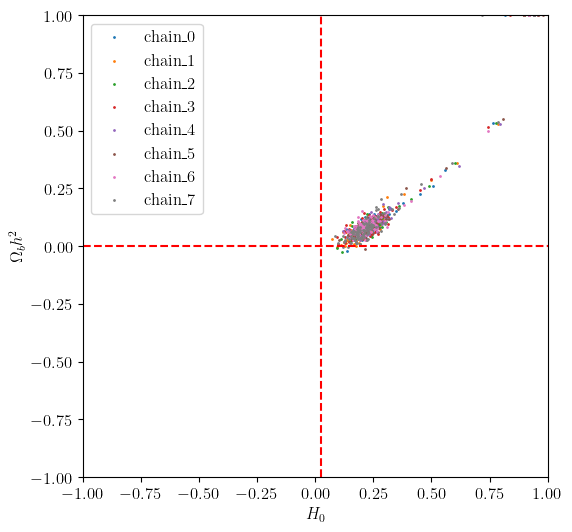

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(tensor_rphi_list.shape[1]):
    ax.scatter(tensor_rphi_list[:, i, 0].detach().cpu().numpy(), tensor_rphi_list[:,i, 1].detach().cpu().numpy(), s=1, alpha=1, label = 'chain_{}'.format(i))
ax.axvline(rphi_true[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax.axhline(rphi_true[0,1].detach().cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
#plt.savefig('phi.png')
plt.show()

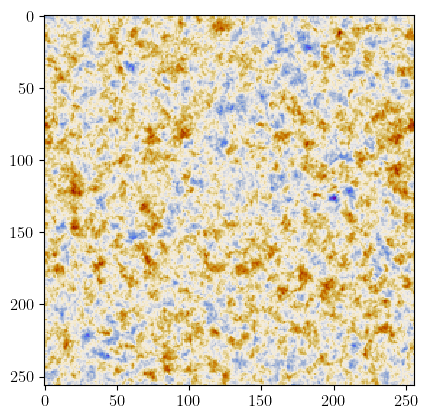

In [337]:
plt.imshow((rescaled_batch-mean)[0,0].cpu().numpy(), cmap='cmb')

In [338]:
stuck_chain = (tensor_rphi_list[50,:]==tensor_rphi_list[-1,:])
stuck_chain = stuck_chain.all(dim=-1)
interesting_chains = [i for i in range(NUM_CHAIN) if not stuck_chain[i]]
interesting_chains

[0, 1, 2, 3, 4, 5, 6, 7]

(-1.0, 1.0)

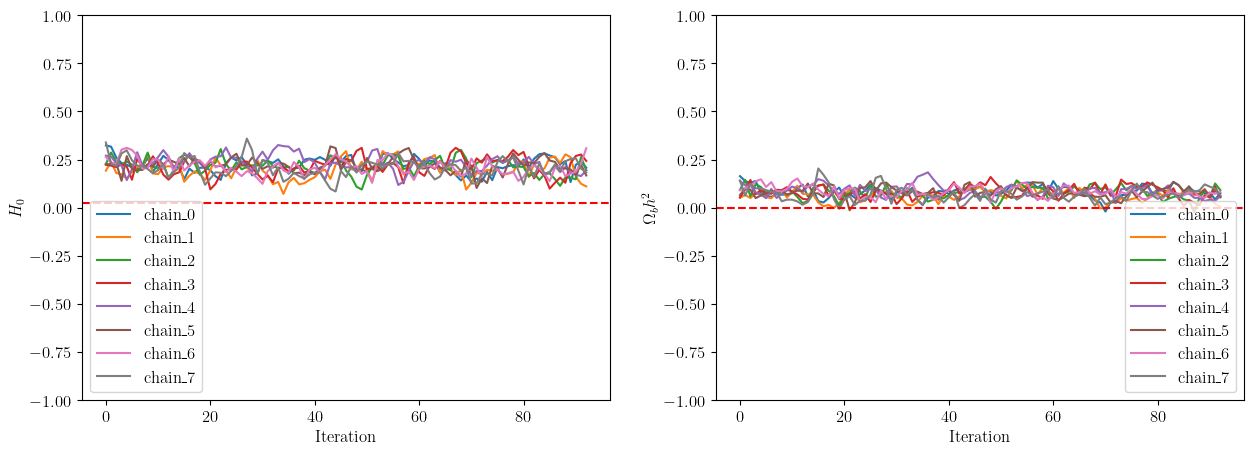

In [339]:
### Trace plots for these chains

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in interesting_chains:
    ax[0].plot(tensor_rphi_list[10:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax[1].plot(tensor_rphi_list[10:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))
ax[0].axhline(rphi_true[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax[1].axhline(rphi_true[0,1].detach().cpu().numpy(), color='red', linestyle='--')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r"$H_0$")
ax[1].set_ylabel(r"$\Omega_b h^2$")
ax[0].legend()
ax[1].legend()
## Set limits to 0,1
ax[0].set_ylim(-1, 1)
ax[1].set_ylim(-1, 1)

In [340]:
az_inf_data = az.convert_to_inference_data(tensor_rphi_list.movedim(1,0)[interesting_chains,10:,:].cpu().detach().numpy())

ess, rhat = az.ess(az_inf_data), az.rhat(az_inf_data)
print(ess['x'].values, rhat['x'].values)

[199.59113244 234.55929912] [1.04288791 1.03443538]


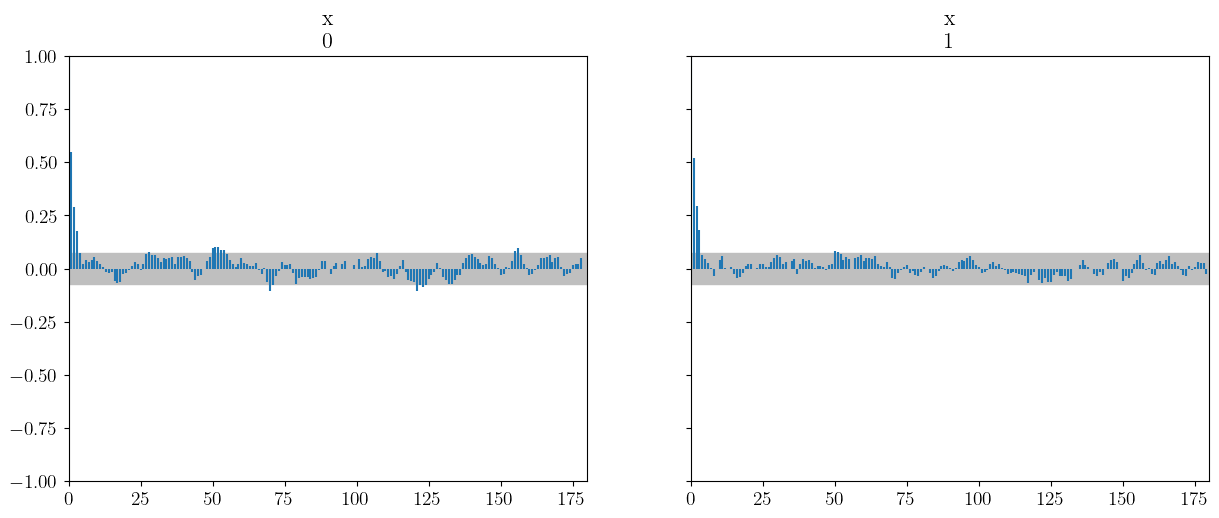

In [341]:
im = az.plot_autocorr(az_inf_data, var_names=['x'], combined = True, max_lag=180)

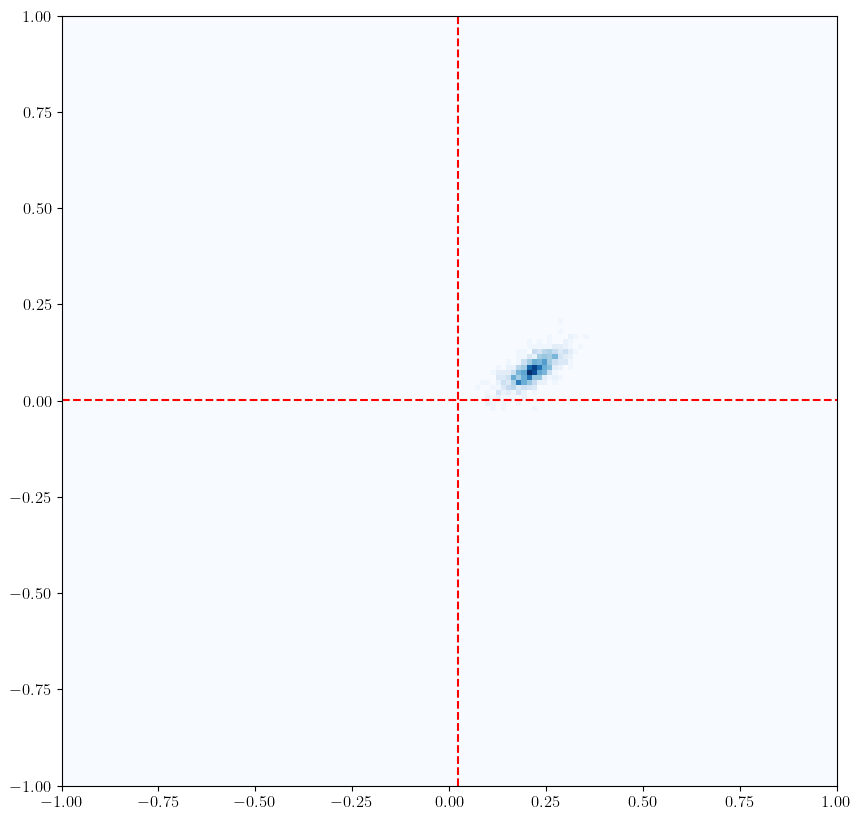

In [342]:
### Method 1 to plot the empirical posterior of the chains using np.hist2d and plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

H0 = tensor_rphi_list[10:, interesting_chains, 0].detach().cpu().numpy().flatten()
Obh2 = tensor_rphi_list[10:, interesting_chains, 1].detach().cpu().numpy().flatten()
H0_test = rphi_true[0,0].detach().cpu().numpy()
Obh2_test = rphi_true[0,1].detach().cpu().numpy()

## plot the histogram, extent [0,1] x [0,1]
## plot the true value as a red dot

out = ax.hist2d(H0, Obh2, bins=150, range=[[-1, 1], [-1, 1]], cmap='Blues')
#ax.scatter(H0, Obh2, s=1, alpha=0.01)
ax.axvline(H0_test, color='red', linestyle='--')
ax.axhline(Obh2_test, color='red', linestyle='--')

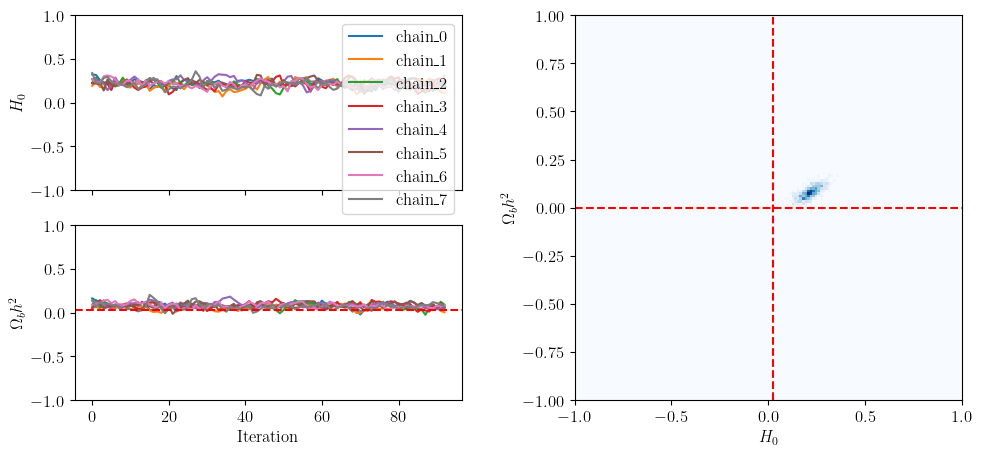

In [343]:
## Plot side by side the traceplots and the histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

subfigs = fig.subfigures(1, 2, wspace=0.1)
ax_left = subfigs[0].subplots(2, 1, sharex=True)

for i in interesting_chains:
    ax_left[0].plot(tensor_rphi_list[10:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax_left[1].plot(tensor_rphi_list[10:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))
ax_left[0].axhline(phi_true[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax_left[1].axhline(phi_true[0,1].detach().cpu().numpy(), color='red', linestyle='--')
ax_left[1].set_xlabel('Iteration')
ax_left[0].set_ylabel(r"$H_0$")
ax_left[1].set_ylabel(r"$\Omega_b h^2$")
ax_left[0].legend()
## Set limits to 0,1
ax_left[0].set_ylim(-1, 1)
ax_left[1].set_ylim(-1, 1)

ax_right = subfigs[1].subplots(1, 1)
ax_right.hist2d(H0, Obh2, bins=150, range=[[-1, 1], [-1, 1]], cmap='Blues')
ax_right.axvline(H0_test, color='red', linestyle='--')
ax_right.axhline(Obh2_test, color='red', linestyle='--')
ax_right.set_xlabel(r"$H_0$")
ax_right.set_ylabel(r"$\Omega_b h^2$")
#plt.savefig('inference_MCMC_{:.2f}.pdf'.format(NOISE_LEVEL), bbox_inches='tight')
plt.show()